# First steps

Welcome! On this page we will guide to you through the first steps required to start working with `hopsy`!

## Installation

``hopsy`` is available on [PyPI](https://pypi.org/project/hopsy/), so you may just install using
```bash
pip install hopsy
```

#### From source

If instead, you want to build ``hopsy`` from source, you need to download the code from GitHub or juGit
```bash
git clone https://jugit.fz-juelich.de/IBG-1/ModSim/hopsy --recursive # or
git clone https://github.com/modsim/hopsy --recursive
```
and either compile a binary wheel using
```bash
pip wheel --no-deps . -w dist
```
or use CMake
```bash
mkdir hopsy/cmake-build-release && cd hopsy/cmake-build-release
cmake ..
make
```
Note however, that the former approach allows you to install the compiled binary wheel using
```bash
pip install dist/hopsy-x.y.z-tag.whl
```

## Polytope sampling in a nutshell

Convex polytope sampling considers the problem of sampling probability densities $f$ supported on a linearly constrained space, i.e. a convex polytope

$$
    \mathcal{P} := \{ x \in \mathbb{R}^d : Ax \leq b \}
$$

with $A \in \mathbb{R}^{n \times d}, b \in \mathbb{R}^n$. Such probability densities can arise for example when performing Bayesian inference on ODE systems, most prominently in metabolic flux analysis [1]_. Often, those probability densities are not analytically tractable and, thus, we need to resort to numerical sampling tools like Markov chain Monte Carlo simulations. ``hopsy`` offers a variety of different samplers for this exact purpose. Moreover, ``hopsy`` aims to be a general purpose sampling library by leveraging the abstract formulation of the polytope sampling problem given earlier. Finally, since polytope sampling remains an open problem with new methods being developed as we speak, ``hopsy`` also allows to implement custom sampling algorithms.

#### Sampling from a simplex

In ``hopsy``, the target density we aim to sample from is defined by a [hopsy.Problem](generated/hopsy.Problem.html#hopsy.Problem), which takes the `A` matrix and `b` vector defining the linear inequality constraints, as well as `model` object. For starters, we will drop the `model` object, in which case we will be sampling the uniform density on $\mathcal{P}$, which in the upcoming example is a simplex:

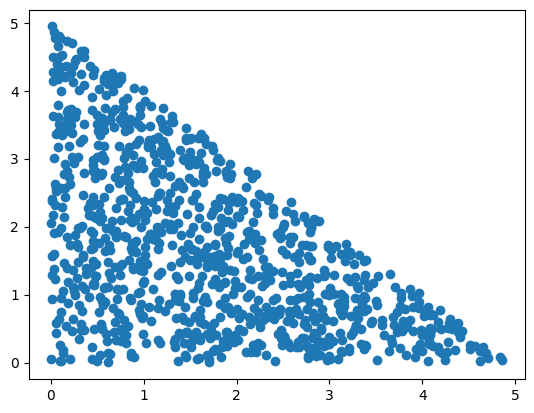

In [4]:
import hopsy
import matplotlib.pyplot as plt

problem = hopsy.Problem(A=[[1, 1], [-1, 0], [0, -1]], b=[5, 0, 0])

chain = hopsy.MarkovChain(problem, starting_point=[.5, .5])
rng = hopsy.RandomNumberGenerator(seed=42)

accrate, samples = hopsy.sample(chain, rng, n_samples=1000, thinning=10)

plt.scatter(samples[:,:,0], samples[:,:,1])
plt.show()

#### Sampling a custom-implemented truncated standard Gaussian

In ``hopsy``, a *model* is any Python-object implementing at least a `log_density` function,
which has to implement a (possibly unnormalized) probability density $f$.

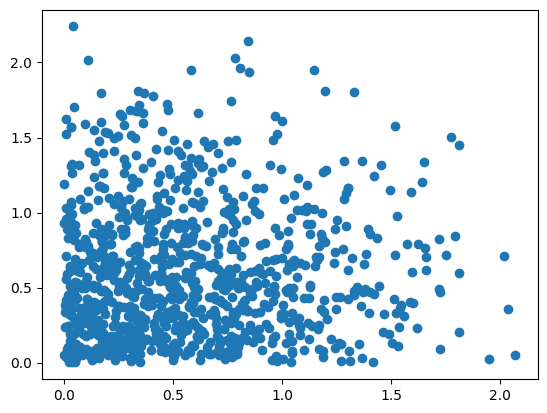

In [5]:
class StandardGaussian:
    def log_density(self, x):
        return -x.dot(x)
    
problem = hopsy.Problem(A=[[1, 1], [-1, 0], [0, -1]], b=[5, 0, 0], 
                        model=StandardGaussian())

chain = hopsy.MarkovChain(problem, starting_point=[.5, .5])
rng = hopsy.RandomNumberGenerator(seed=42)

accrate, samples = hopsy.sample(chain, rng, n_samples=1000, thinning=10)

plt.scatter(samples[:,:,0], samples[:,:,1])
plt.show()

#### Sampling with a custom sampler

For demonstration purposes, we next try to sample previous distribution by a sampler which proposes new states from a cube. In the easiest case, a proposer only needs to implement a `propose` method. For non-symmetric proposal distributions, a ``log_acceptance_probability`` method needs to be provided as well. This is covered in more in-depth in our [sampling user guide](userguide/sampling.rst).

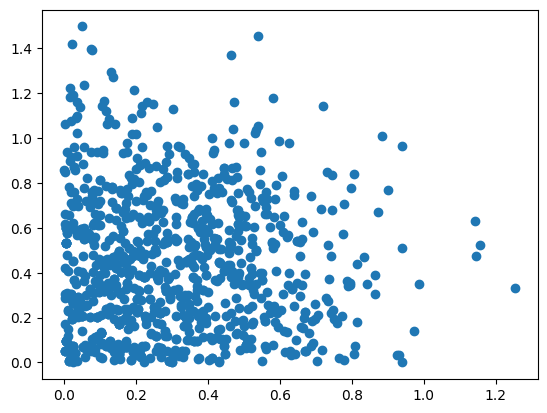

In [6]:
class CubeProposal:
    uniform = hopsy.Uniform(-1, 1)
    def propose(self, rng):
        return [self.state[0] + self.uniform(rng), self.state[1] + self.uniform(rng)]

chain = hopsy.MarkovChain(problem, proposal=CubeProposal, starting_point=[.5, .5])
rng = hopsy.RandomNumberGenerator(seed=42)

accrate, samples = hopsy.sample(chain, rng, n_samples=1000, thinning=10)

plt.scatter(samples[:,:,0], samples[:,:,1])
plt.show()


.. rubric:: Footnotes

.. [1] https://doi.org/10.1002/bit.26379